# CartPole - V0
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. For more information visit https://gym.openai.com/envs/CartPole-v0/.

## 1. Import libraries

In [1]:
import gym
import math
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
from itertools import count
from collections import namedtuple
from tqdm.auto import tqdm, trange
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

## 2. Hyper Parameters

In [2]:
episodes = 1000 # Number of episodes (epochs)
lr = 0.001 # Learning rate
gamma = 0.999  # Discount rate
exp_rate = 1  # Epsilon (Expectation rate)
exp_high = 1 # Highest Epsilon
exp_low = 0.01 # Lowest Epsilon
exp_decay = 0.001 # Expecation rate decay
batch_size = 256 # Size of batches
memory_size = 100000 # Size of replay memory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 3. Model (Deep Q-Network)

In [3]:
class DQN(nn.Module):
    def __init__(self, height, width):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(height*width*3, 24), # 3 for RGB
            nn.ReLU(inplace=True),
            nn.Linear(24, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 2) # Left or Right
        )
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return self.model(x)

## 4. Replay Memory and Experience

In [4]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    def add_exp(self, exp):
        if (len(self.memory)< self.capacity):
            self.memory.append(exp)
        else:
            self.memory.pop(0)
            self.memory.insert(0, exp)
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

In [5]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward'))

## 5. Agent

In [6]:
class Agent:
    def __init__(self, num_actions=2):
        self.current_step = 0
        self.num_actions = num_actions
    def greedy_strategy(self, current_step):
        return exp_low + (exp_high - exp_low) * math.exp(-1* exp_decay * current_step)
    def step(self, state, model):
        thresh = self.greedy_strategy(self.current_step)
        self.current_step +=1
        # Exploitation
        if thresh <= random.random():
            with torch.no_grad():
                return model(state).argmax(dim=1).to(device)
        # Exploration
        else:
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(device)

## 6. Environment

In [7]:
class Environment:
    def __init__(self):
        self.env = gym.make("CartPole-v0").unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False

    def reset_env(self):
        self.env.reset()
        self.current_screen = None

    def close_env(self):
        self.env.close()

    def render_env(self, mode="human"):
        return self.env.render(mode)

    def get_actions(self):
        return self.env.action_space.n

    def get_state(self):
        if self.current_screen is None or self.done:
            self.current_screen = self.process_screen()
            return torch.zeros_like(self.current_screen)
        else:
            state = self.current_screen
            new_state = self.process_screen()
            self.current_screen = new_state
            return new_state - state
    
    def get_height(self):
        return self.process_screen().shape[2]
    
    def get_width(self):
        return self.process_screen().shape[3]

    def crop_screen(self, screen):
        top = int(screen.shape[1] * 0.4)
        bottom = int(screen.shape[1] * 0.8)
        return screen[:, top: bottom, :]
    
    def transform_screen(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        resize = T.Compose([T.ToPILImage(), T.Resize((40,90)), T.ToTensor()])
        return resize(screen).unsqueeze(0).to(device)
    
    def process_screen(self):
        screen = self.render_env('rgb_array').transpose((2,0,1))
        screen = self.crop_screen(screen)
        return self.transform_screen(screen)

    def step(self, action):
        new_state, reward, self.done, info = self.env.step(action.item())
        return torch.tensor([reward]).to(device)

## 7. Initialization

In [8]:
env = Environment()
agent = Agent(env.get_actions())
memory = ReplayMemory(memory_size)
policy_net = DQN(env.get_height(), env.get_width()).to(device)
target_net = DQN(env.get_height(), env.get_width()).to(device)
target_net.load_state_dict(policy_net.state_dict()) # copy the policy net
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr= lr)

## 8. Q-Values Calculator

In [9]:
def get_current_q(policy_net, states, actions):
    return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

def get_next_q(target_net, next_states):
    batch_size = next_states.shape[0]
    final_locs = next_states.reshape(batch_size, -1).max(dim=1)[0].eq(0).type(torch.bool)
    non_final = next_states[final_locs == False]
    values = torch.zeros(batch_size).to(device)
    values[final_locs == False] = target_net(non_final).max(dim=1)[0].detach()

    return values

## 8. Plotting the Results

In [10]:
def plot(values, period):
    plt.figure(2)
    plt.clf()
    plt.title("Training")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(values)
    
    # Get periods
    values = torch.tensor(values, dtype=torch.float)
    if (len(values)) > period:
        moving_avg = values.unfold(dimension=0, size= period, step= 1).mean(dim=1).reshape(-1)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
    else:
        moving_avg = torch.zeros(len(values))
    plt.plot(moving_avg.numpy())
    plt.pause(0.001)
    print(f"EPISODE {len(values)} with {moving_avg[-1]}")
    clear_output(wait=True)

## 9. Training

In [11]:
def extract_tensors(exps):
    batch = Experience(*zip(*exps)) # Create experience of batches

    states = torch.cat(batch.state)
    actions = torch.cat(batch.action)
    rewards = torch.cat(batch.reward)
    next_states = torch.cat(batch.next_state)

    return states, actions, rewards, next_states

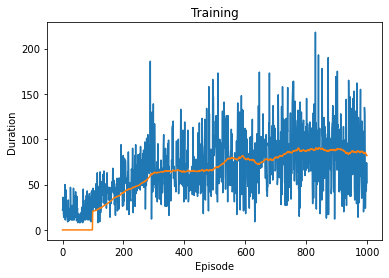

EPISODE 1000 with 82.02999877929688


In [12]:
durations = []
for e in range(episodes):
    env.reset_env()
    state = env.get_state()

    for timestep in count():
        action = agent.step(state, policy_net)
        reward = env.step(action)
        new_state = env.get_state()
        memory.add_exp(Experience(state, action, new_state, reward))
        state = new_state

        if len(memory.memory) >= batch_size:
            experiences = memory.sample(batch_size)
            states, actions, rewards, new_states = extract_tensors(experiences)

            current_q = get_current_q(policy_net, states, actions)
            next_q =get_next_q(target_net, new_states)
            target_q = next_q * gamma + rewards

            loss = F.mse_loss(current_q, target_q.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if env.done:
            durations.append(timestep)
            plot(durations, 100)
            break
    if e % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())

env.close_env()